In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json


In [63]:
dataframe = pd.read_csv("files/dataframe/pillar_data_clinvar38_annotated_final_v14_spliceai_032525.csv")
dataframe = dataframe.assign(auth_reported_score=pd.to_numeric(dataframe.auth_reported_score, errors='coerce'))

/tmp/ipykernel_2843385/453182847.py:1: DtypeWarning: Columns (4,11,13,14,15,21,22,23,34,37,38,39,40,43,44,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv("files/dataframe/pillar_data_clinvar38_annotated_final_v14_spliceai_032525.csv")


In [64]:
summaries_path = Path("files/model_selection_04_03_2025_P3_summaries/")
summary_figures_path = summaries_path / "summary_figures"
summary_figures_path.mkdir(exist_ok=True, parents=True)
scoreset_summaries = {
    summary_file.stem.replace("_summary","") : json.load(summary_file.open())
    for summary_file in summaries_path.glob("*.json")
}

# Evaluate Evidence Strength Distributions by Assay

In [65]:
bin2score = {0: 1,
            1: 2,
            2: 3,
            3: 4,
            4: 8}

def get_scoreset_strengths(scoreset_summary):
    exceeds_pathogenic = np.where(pd.notnull(scoreset_summary['pathogenic_thresholds']))[0]
    exceeds_benign = np.where(pd.notnull(scoreset_summary['benign_thresholds']))[0]
    pathogenic_strength = 0
    benign_strength = 0
    if len(exceeds_pathogenic):
        pathogenic_strength = bin2score[exceeds_pathogenic[-1]]
    if len(exceeds_benign):
        benign_strength = -1 * bin2score[exceeds_benign[-1]]
    return pathogenic_strength, benign_strength

In [66]:
scoreset_pathogenic_strengths, scoreset_benign_strengths = list(map(np.array,zip(*[get_scoreset_strengths(scoreset_summary) for scoreset_summary in scoreset_summaries.values()])))

In [67]:
(scoreset_pathogenic_strengths == 8).sum() / len(scoreset_pathogenic_strengths)

np.float64(0.4375)

/tmp/ipykernel_2843385/511832907.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = plt.gca().set_yticklabels([f"{int(tick * 100)}%" for tick in plt.gca().get_yticks()])


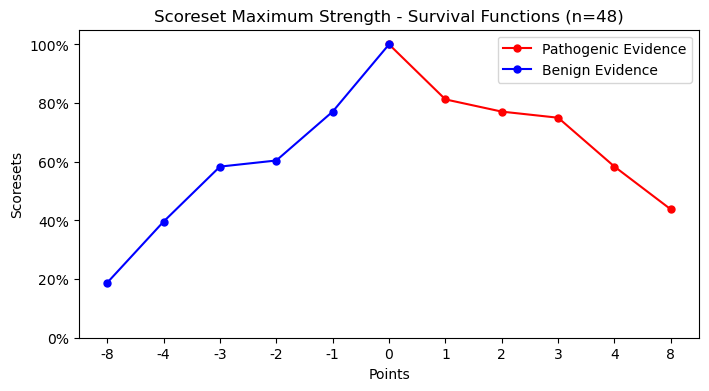

In [68]:
pointvals = np.array([0,1,2,3,4,8])
ecdfs_pathogenic = np.zeros(len(pointvals))
ecdfs_benign = np.zeros(len(pointvals))
for idx,pointval in enumerate(pointvals):
    ecdfs_pathogenic[idx] = np.sum(np.array(scoreset_pathogenic_strengths) >= pointval) / len(scoreset_pathogenic_strengths)
    ecdfs_benign[idx] = np.sum(np.array(scoreset_benign_strengths) <= (-1 * pointval)) / len(scoreset_benign_strengths)
fig = plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(ecdfs_pathogenic)), ecdfs_pathogenic, marker='o', markersize=5, color='red', label="Pathogenic Evidence")
plt.plot(-1 * np.arange(len(ecdfs_pathogenic)), ecdfs_benign, marker='o', markersize=5, color='blue', label="Benign Evidence")
_ = plt.gca().set_xticks(np.arange(-5,6),[* (-1 * pointvals[1:][::-1]).astype(str),
                                      * pointvals.astype(str)])
_ = plt.gca().set_xlabel("Points")
_ = plt.gca().set_ylabel("Scoresets")
plt.gca().set_ylim(0,1.05)
_ = plt.gca().set_yticklabels([f"{int(tick * 100)}%" for tick in plt.gca().get_yticks()])
plt.gca().set_title(f"Scoreset Maximum Strength - Survival Functions (n={len(scoreset_pathogenic_strengths)})")
plt.gca().legend()

fig.savefig(summary_figures_path / "scoreset_strengths_survival_functions.png", dpi=300, bbox_inches='tight')

In [69]:



def assign_evidence(row, scoreset_summary):
    if scoreset_summary is None:
        return np.nan
    score = row.auth_reported_score
    if not isinstance(score,float):
        return np.nan
    pathogenic_thresholds = scoreset_summary['pathogenic_thresholds']
    benign_thresholds = scoreset_summary['benign_thresholds']
    if np.isnan(pathogenic_thresholds[0]) and np.isnan(benign_thresholds[0]): # If no evidence is met by the assay
        return 0
    elif pathogenic_thresholds[0] < benign_thresholds[0]: # assay is 'conventional'
        return get_evidence_points(score, pathogenic_thresholds, benign_thresholds, conventional=True)
    else: # assay is 'reverse'
        return get_evidence_points(score, pathogenic_thresholds, benign_thresholds, conventional=False)

def get_evidence_points(score, pathogenic_thresholds, benign_thresholds,conventional=True):
    
    pathogenic_thresholds = np.array(pathogenic_thresholds)
    benign_thresholds = np.array(benign_thresholds)
    if conventional:
        exceeds_pathogenic = np.where(score <= pathogenic_thresholds)[0]
        exceeds_benign = np.where(score >= benign_thresholds)[0]
    else:
        exceeds_pathogenic = np.where(score >= pathogenic_thresholds)[0]
        exceeds_benign = np.where(score <= benign_thresholds)[0]
    if not len(exceeds_pathogenic) and not len(exceeds_benign):
        return 0
    if len(exceeds_pathogenic):
        return bin2score[exceeds_pathogenic[-1]]
    if len(exceeds_benign):
        return -1 * bin2score[exceeds_benign[-1]]

In [70]:
from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Apply the function with progress bar
dataframe = dataframe.assign(points=dataframe.progress_apply(
    lambda row: assign_evidence(row, scoreset_summaries.get(row.Dataset, None)), axis=1) # type: ignore
)

  0%|          | 0/1053714 [00:00<?, ?it/s]

100%|██████████| 1053714/1053714 [00:19<00:00, 55373.71it/s]


Check if we reject the fit on any dataset

In [72]:
[k for k,v in scoreset_summaries.items() if v['fit_quality_summary']['gnomAD']['0.5'] > 0.2 or \
                                    v['fit_quality_summary'].get('synonymous',{}).get('0.5',0) > 0.2]

[]

In [93]:
def infer_author_label(row):
    if pd.notnull(row.auth_reported_func_class) and pd.isna(pd.to_numeric(row.auth_reported_func_class, errors='coerce')):
        # If the author reported functional class string, return it
        return row.auth_reported_func_class
    amin,amax,nmin,nmax = row.auth_reported_abnormal_min, row.auth_reported_abnormal_max, \
                            row.auth_reported_normal_min, row.auth_reported_normal_max
    score = row.auth_reported_score
    if pd.notnull(amax) and pd.notnull(nmin) and amax < nmin:
        # Assay is conventional
        if score < amax:
            return "FA"
        elif score > nmin:
            return "FN"
        else:
            return "INT"
    elif pd.notnull(amin) and pd.notnull(nmax) and amin > nmax:
        # Assay is reverse
        if score > amin:
            return "FA"
        elif score < nmax:
            return "FN"
        else:
            return "INT"
    else:
        # Cannot infer assay type
        return "UNK"

In [ ]:
author2Standard = {'nan':"UNK",
                   'high_activity':"FN",
                    'low_activity':"FA",
                    'non-significant':"UNK",
                    'Loss': "FA",
                    'Partial':"FA",
                    'Normal':"FN",
                    'Gain':"GOF",
                    'Possible':"FA",
                    'PossibleGain':"GOF",
                    'normal': "FN",
                    'abnormal':"FA",
                    'uncertain':"INT",
                    'Hypomorphic':"FA",
                    'Unimpaired':"FN",
                    'Amorphic': "FA",
                    'LOF':"FA",
                    'possiblyWT':"FN",
                    'WT':"FN",
                    'possiblyLOF':"FA",
                    'GOF':"GOF",
                    'possiblyGOF': "GOF",
                    'severe LOF':"FA",
                    'moderate LOF':"FA",
                    'Non-Functional':"FA",
                    'Functional': "FN",
                    'Functionally normal':"FN",
                    'Functionally abnormal':"FA",
                    'FUNC':"FN",
                    'INT': "INT",
                    'Abnormal':"FA",
                    'Intermediate':"INT",
                    'Neutral':"FN",
                    'LOF1':"FA",
                    'LOF2': "FA",
                    'Likely abnormal':"FA",
                    'unchanged':"FN",
                    'depleted':"FA",
                    'enriched': "FN",
                    'slow depleting':"FA",
                    'fast depleting':"FA",
                    'Deleterious':"FA",
                    'Uncertain': "INT",
                    'fast depleted':"FA",
                    'slow depleted':"FA",
                    'damaging_severe':"FA",
                    'functional': "FN",
                    'damaging_mild':"FA",
                    'damaging_intermediate':"FA",
                    'damaging':"FA"}

array(['nan', 'high_activity', 'low_activity', 'non-significant', 'Loss',
       'Partial', 'Normal', 'Gain', 'Possible', 'PossibleGain', 'normal',
       'abnormal', 'uncertain', 'Hypomorphic', 'Unimpaired', 'Amorphic',
       'LOF', 'possiblyWT', 'WT', 'possiblyLOF', 'GOF', 'possiblyGOF',
       'severe LOF', 'moderate LOF', 'Non-Functional', 'Functional',
       'Functionally normal', 'Functionally abnormal', 'FUNC', 'INT',
       'Abnormal', 'Intermediate', 'Neutral', 'LOF1', 'LOF2',
       'Likely abnormal', 'unchanged', 'depleted', 'enriched',
       'slow depleting', 'fast depleting', 'Deleterious', 'Uncertain',
       'fast depleted', 'slow depleted', 'damaging_severe', 'functional',
       'damaging_mild', 'damaging_intermediate', 'damaging', '0.0', '1.0'],
      dtype=object)

In [94]:
dataframe = dataframe.assign(inferred_author_label=dataframe.progress_apply(
    lambda row: infer_author_label(row), axis=1) # type: ignore
)

100%|██████████| 1053714/1053714 [00:28<00:00, 37177.22it/s]


# Dataset-specific comparison of author annotation vs. point assignment

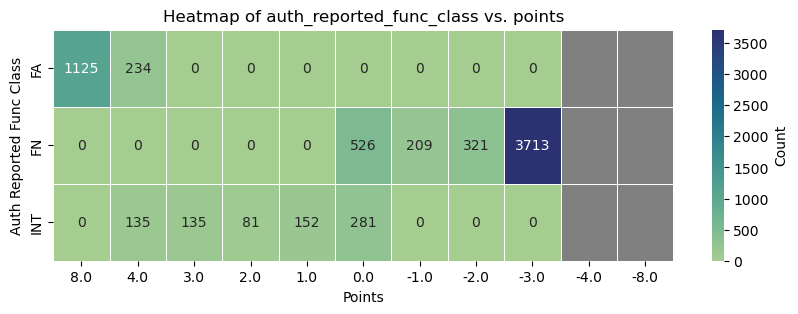

In [95]:
scoreset_name = "PTEN_Mighell_2018"
# Filter the dataframe
filtered_df = dataframe[
    (dataframe['Dataset'] == scoreset_name) &
    (dataframe['simplified_consequence'] == 'Missense')
]
filtered_df = filtered_df.assign(inferred_author_label=filtered_df.inferred_author_label.astype(str))

# Create a pivot table
pivot_table = filtered_df.pivot_table(
    index='inferred_author_label',
    columns='points',
    aggfunc='size',
    fill_value=0
)
# Ensure all desired columns are present in the pivot table
desired_columns = [-8, -4, -3, -2, -1, 0, 1, 2, 3, 4, 8]
for col in desired_columns:
    if col not in pivot_table.columns:
        pivot_table[col] = 0

# Reorder the columns to match the desired order
pivot_table = pivot_table.loc[:,desired_columns]

# Plot the heatmap
plt.figure(figsize=(10, 3))

mask = np.zeros_like(pivot_table, dtype=bool)
scoreset_pathogenic_thresholds = np.array(scoreset_summaries[scoreset_name]['pathogenic_thresholds'])
scoreset_benign_thresholds = np.array(scoreset_summaries[scoreset_name]['benign_thresholds'])
for idx,threshold in enumerate(scoreset_benign_thresholds[::-1]):
    if np.isnan(threshold):
        mask[:,idx] = np.nan
for idx,threshold in enumerate(scoreset_pathogenic_thresholds,start=-5):
    if np.isnan(threshold):
        mask[:,idx] = np.nan
pivot_table = pivot_table.iloc[:,::-1]  # Reverse the order of the columns for plotting
mask = mask[:,::-1]  # Reverse the order of the mask for plotting
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(pivot_table, annot=True, cmap=cmap, mask=mask, cbar_kws={'label': 'Count'}, fmt='d',
            linewidths=0.5)
plt.gca().set_facecolor("gray")
plt.title('Heatmap of auth_reported_func_class vs. points')
plt.xlabel('Points')
plt.ylabel('Auth Reported Func Class')
plt.show()

In [90]:
filtered_df.inferred_author_label.unique()

array(['1.0', '0.0', 1.0, 0.0], dtype=object)

In [92]:
filtered_df

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,auth_reported_normal_min,auth_reported_normal_max,auth_reported_abnormal_min,auth_reported_abnormal_max,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,Flag,CHROM,POS,REF,ALT,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL,SpliceAI_score,points,inferred_author_label
1046185,PTEN_Mighell_2018_var87573,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87864473.0,87864475.0,ACA,GCT,NM_000314.6,4-6,NaN,NaN,2.0,T,A,c.4_6delinsGCT,p.Thr2Ala,missense_variant,2.275492,NaN,1.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,1.0
1046186,PTEN_Mighell_2018_var87574,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87864473.0,87864475.0,ACA,GTT,NM_000314.6,4-6,NaN,NaN,2.0,T,V,c.4_6delinsGTT,p.Thr2Val,missense_variant,1.399574,NaN,1.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,1.0
1046187,PTEN_Mighell_2018_var87577,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87864474.0,87864475.0,CA,TG,NM_000314.6,5-6,NaN,NaN,2.0,T,M,c.5_6inv,p.Thr2Met,missense_variant,2.263684,NaN,1.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,1.0
1046188,PTEN_Mighell_2018_var87578,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87864473.0,87864475.0,ACA,TTT,NM_000314.6,4-6,NaN,NaN,2.0,T,F,c.4_6delinsTTT,p.Thr2Phe,missense_variant,0.531942,NaN,0.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,0.0
1046189,PTEN_Mighell_2018_var87580,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87864473.0,87864475.0,ACA,TGG,NM_000314.6,4-6,NaN,NaN,2.0,T,W,c.4_6delinsTGG,p.Thr2Trp,missense_variant,0.130126,NaN,1.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053709,PTEN_Mighell_2018_var96397,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87965467.0,87965469.0,GTC,ATT,NM_000314.6,1207-1209,NaN,NaN,403.0,V,I,c.1207_1209delinsATT,p.Val403Ile,missense_variant,-2.049575,NaN,0.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
1053710,PTEN_Mighell_2018_var96399,PTEN_Mighell_2018,PTEN,9588.0,10,1.0,NaN,87965467.0,87965469.0,GTC,ATG,NM_000314.6,1207-1209,NaN,NaN,403.0,V,M,c.1207_1209delinsATG,p.Val403Met,missense_variant,0.106511,NaN,1.0,-1.11,0.89,-5.76,-2.13,No,NaN,NaN,NaN,NaN,aa,urn:mavedb:00000054-a-1,ENST00000371953.8,NM_000314.6,yeast,Cell Viability,Cell growth,lipid phosphatase activity,No,Missense,NaN,NaN,NaN,NaN,NaN,NaN,